In [25]:
from matplotlib import pyplot as plt
%matplotlib inline
import urllib.request, io
import pandas as pd

n=800
furl = "http://192.168.4.1/immediate/batacc/n=%d"%n
fin = urllib.request.urlopen(furl)
rc = fin.read()


sample rate (millis) mean, std 16.8397997497 0.892389408886


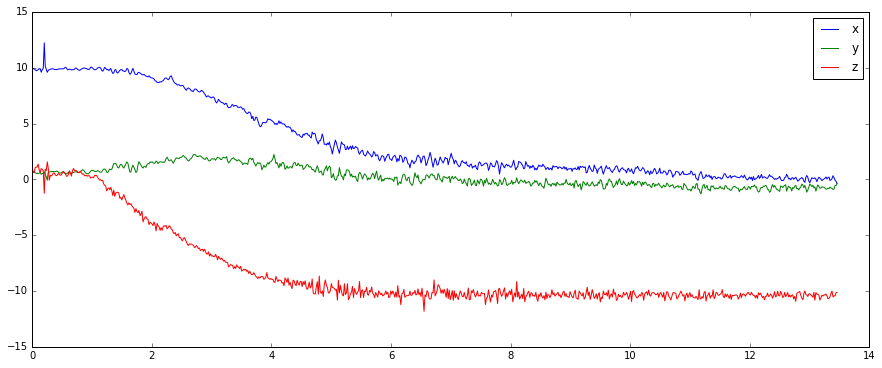

In [26]:
k = pd.read_csv(io.BytesIO(rc))
ti = k.columns[0]
fac = 1/1638.4

print("sample rate (millis) mean, std", k[ti].diff().mean(), k[ti].diff().std())

k = pd.DataFrame(data={"x":k.x*fac, "y":k.y*fac, "z":k.z*fac, "t":k[ti]*0.001}).set_index("t")


plt.figure(figsize=(15,6))
plt.plot(k.x)
plt.plot(k.y)
plt.plot(k.z)
plt.legend()



(array([ 0.00041655,  0.00124964,  0.00124964,  0.00041655]),
 array([ 1.        , -2.6861574 ,  2.41965511, -0.73016535]))

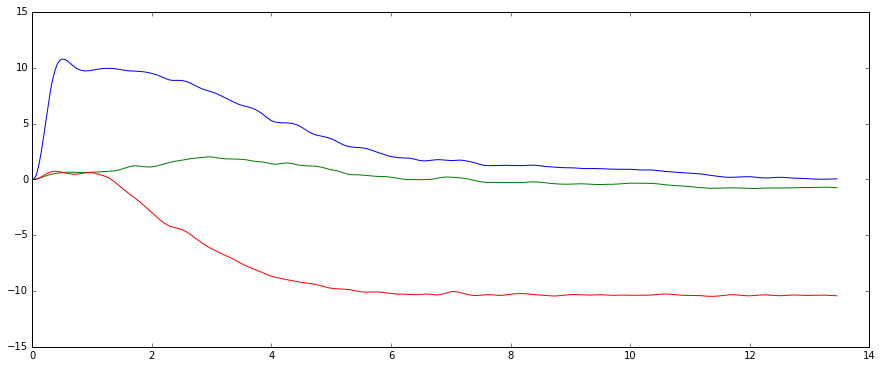

In [30]:
import scipy.signal
b, a = scipy.signal.butter(3, 0.05, 'low')
plt.figure(figsize=(15,6))
h = pd.DataFrame(data={"x":scipy.signal.lfilter(b, a, k.x), 
                       "y":scipy.signal.lfilter(b, a, k.y), 
                       "z":scipy.signal.lfilter(b, a, k.z) },
                 index=k.index)

#plt.plot(k.index, scipy.signal.filtfilt(b, a, k.x))
#plt.plot(k.index, scipy.signal.filtfilt(b, a, k.y))
#plt.plot(k.index, scipy.signal.filtfilt(b, a, k.z))
#plt.legend()
plt.plot(h)
b, a

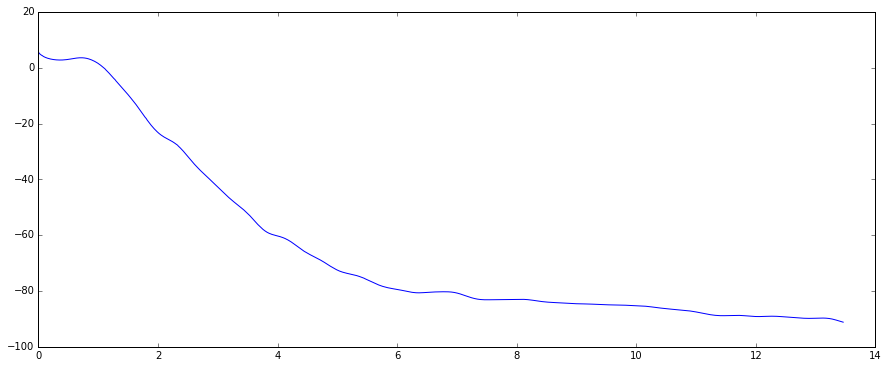

In [28]:
import math
plt.figure(figsize=(15,6))
j = h.apply(lambda r: math.degrees(math.atan2(r.z, r.x)), axis=1)
plt.plot(j)

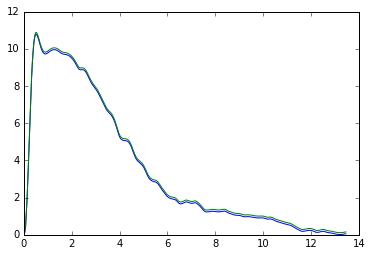

In [36]:
b = [ 0.00041655,  0.00124964,  0.00124964,  0.00041655]
a = [ 1.        , -2.6861574 ,  2.41965511, -0.73016535]

n = len(a)
xybuff = [0]*(2*len(a))
xybuffpos = 0; 

def addvalueF(x):
    global xybuffpos, xybuff
    if n == 0:
        y = xybuff[0]; 
        xybuff[2] = y; 
        xybuff[0] = x*xybuff[1] + y*(1-xybuff[1]); 
        return xybuff[0]; 
    
    xybuff[xybuffpos] = x; 
    j = xybuffpos; 
    y = 0; 
    for i in range(n):
        y += xybuff[j]*b[i] 
        if i != 0:
            y -= xybuff[j+n]*a[i] 
        if j == 0:
            j = n; 
        j -= 1; 
            
    if a[0] != 1:
        y /= a[0]; 
    xybuff[xybuffpos+n] = y; 
    xybuffpos += 1;
    if xybuffpos == n:
        xybuffpos = 0; 

    j = (n-1 if xybuffpos == 0 else xybuffpos-1)
    return xybuff[j+n] 

plt.plot(k.index, scipy.signal.lfilter(b, a, k.x))
kf = [ addvalueF(x)+0.1  for x in k.x ]
plt.plot(k.index, kf)


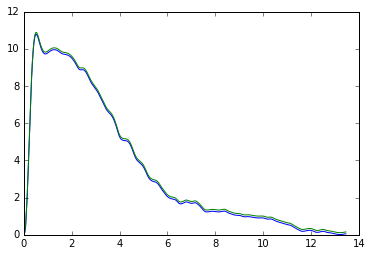

In [40]:
b = [ 0.00041655,  0.00124964,  0.00124964,  0.00041655]
a = [ 1.        , -2.6861574 ,  2.41965511, -0.73016535]

class butt:
    def __init__(self):
        self.n = len(a)
        self.xybuff = [0]*(2*self.n)
        self.xybuffpos = 0

    def addvalueF(self, x):
        self.xybuff[self.xybuffpos] = x; 
        j = self.xybuffpos 
        y = 0; 
        for i in range(self.n):
            y += self.xybuff[j]*b[i] 
            if i != 0:
                y -= self.xybuff[j+self.n]*a[i] 
            if j == 0:
                j = self.n; 
            j -= 1; 

        if a[0] != 1:  y /= a[0]; 
        self.xybuff[self.xybuffpos+self.n] = y; 
        self.xybuffpos += 1;
        if self.xybuffpos == self.n:
            self.xybuffpos = 0; 

        j = (self.n-1  if self.xybuffpos == 0  else self.xybuffpos-1)
        return self.xybuff[j+self.n] 

bt = butt()    
plt.plot(k.index, scipy.signal.lfilter(b, a, k.x))
kf = [ bt.addvalueF(x)+0.1  for x in k.x ]
plt.plot(k.index, kf)



In [ ]:
ABFilter::ABFilter(const float* la, const float* lb, int ln, float ltimestep) :
    a(la), b(lb), n(ln), timestep(ltimestep)
{
    xybuff = (float*)malloc(2*n*sizeof(float)); 
    for (int i = 0; i < 2*n; i++)
        xybuff[i] = 0; 
    xybuffpos = 0; 

    t0 = -1.0; 
    prevt = -1.0; 
    prevx = -1.0; 
    sumX = 0.0; 
}

ABFilter::ABFilter(float b0, float ltimestep) :
    a(0), b(0), n(0), timestep(ltimestep)
{
    xybuff = (float*)malloc(3*sizeof(float)); // xybuff[0] is the y, xybuff[1] is the decayfactor, xybuff[2] is prev-y
    xybuff[0] = 0; 
    xybuff[1] = b0; 
    xybuff[2] = 0; 
    xybuffpos = -1; 

    t0 = -1.0; 
    prevt = -1.0; 
    prevx = -1.0; 
    sumX = 0.0; 
}

float ABFilter::expdecayfac(float dt, float decaypersec)
{
    return 1 - exp(-dt*decaypersec); 
} 


bool ABFilter::addvalueT(float t, float x)
{
    //P("addvalueT "); P(t); P(" "); P(x);     
    // assert t0 <= prevt <= t0 + timestep; 
    if (t <= t0) {
        prevx = x; 
    //P(" t<t0\n");         
        return false; 
    }
    if (t < t0 + timestep) {
        sumX += (t - prevt)*(x + prevx)*0.5; 
        prevt = t; 
        prevx = x; 
        //P(" t<t0+timestep\n");         
        return false; 
    }
    float lam = (t0 + timestep - prevt)/(t - prevt); 
    //assert 0 <= lam <= 1; 
    float xlam = prevx*(1 - lam) + x*lam; 
    //P(" lam "); P(lam); P(" xlam "); P(xlam); 
    // float tlam = prevt*(1 - lam) + t*lam == prevt + lam*(t - prevt) == prevt + (t0 + timestep - prevt) == t0 + timestep 
    sumX += (t0 + timestep - prevt)*(xlam + prevx)*0.5; 
    t0 = t0 + timestep; 
    nt0bytimestep++; 
    // TOL_ZERO(t0 - nt0bytimestep*timestep); 
    //P(" t0 "); P(t0); P("\n");     
    prevt = t0; 
    prevx = xlam; 
    return true; 
}

void ABFilter::addvalueF(float x)
{
//P("addvalueF "); P(x); P("\n");     
    if (n == 0) {
        float y = xybuff[0]; 
        xybuff[2] = y; 
        xybuff[0] = x*xybuff[1] + y*(1-xybuff[1]); 
        return; 
    }
    
    xybuff[xybuffpos] = x; 
    int j = xybuffpos; 
    float y = 0; 
    for (int i = 0; i < n; i++) {
        y += xybuff[j]*b[i]; 
        if (i != 0)
            y -= xybuff[j+n]*a[i]; 
        if (j == 0)
            j = n; 
        j -= 1; 
    }
    if (a[0] != 1)
        y /= a[0]; 
    xybuff[xybuffpos+n] = y; 
    xybuffpos += 1;
    if (xybuffpos == n)
        xybuffpos = 0; 
}

void ABFilter::firstvalue(float t, float x)
{
    nt0bytimestep = (int)floor(t/timestep); 
    t0 = nt0bytimestep*timestep; // get the timesteps syncronized!
    t0 = t; 
    prevt = t0; 
    prevx = x; 
    sumX = 0; 

    if (n == 0) {
        xybuff[0] = x; 
        P("Setting exp filter "); P(xybuff[0]); P("  dt "); P(timestep); P("\n"); 
        xybuff[2] = x; 
    } else {
        for (int i = 0; i < 2*n; i++)
            xybuff[i] = x; 
    }
}


void ABFilter::addvalue(float t, float x)
{
    if (t0 == -1) {
        firstvalue(t, x); 
        return; 
    }
    if (abs(t - t0) > timestep*64) {  
        firstvalue(t, x); 
        P(" big timestep, restarting filter\n"); 
        return; 
    }
    
    int i = 64; // protect against infinite loops
    while (addvalueT(t, x) && (i-- > 0)) {
        addvalueF(sumX/timestep); 
        sumX = 0; 
    }
}

float ABFilter::filtval()
{
    if (n == 0) 
        return xybuff[0]; 
    int j = (xybuffpos == 0 ? n-1 : xybuffpos-1); 
    return xybuff[j+n]; 
}

float ABFilter::difffiltval() 
{
    if (n == 0) 
        return (xybuff[0] - xybuff[2])/timestep; 
    int j = (xybuffpos == 0 ? n-1 : xybuffpos-1); 
    int j1 = (j == 0 ? n-1 : j-1); 
    float res = (xybuff[j+n] - xybuff[j1+n])/timestep; 
    return res; 
}
